## **Project Title: Local Food Wastage Management System**

**BY Shubham Pandey**

**Git Hub: https://github.com/Shubhampandey1git/Local-Food-Wastage-Management-System.git**

#### **Problem statement:**
Food wastage is a significant issue, with many households and restaurants discarding surplus food while numerous people struggle with food insecurity. This project aims to develop a Local Food Wastage Management System, where:

* Restaurants and individuals can list surplus food.
* NGOs or individuals in need can claim the food.
* SQL stores available food details and locations.
* A Streamlit app enables interaction, filtering, CRUD operation and visualization. 


# **Imports**

In [26]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

## **Dataset Loading**

In [2]:
providers = pd.read_csv("data/providers_data.csv")
receivers = pd.read_csv("data/receivers_data.csv")
food_listings = pd.read_csv("data/food_listings_data.csv", parse_dates=["Expiry_Date"])
claims = pd.read_csv("data/claims_data.csv", parse_dates=["Timestamp"])

In [3]:
print(food_listings.head())

   Food_ID Food_Name  Quantity Expiry_Date  Provider_ID     Provider_Type  \
0        1     Bread        43  2025-03-17          110     Grocery Store   
1        2      Soup        22  2025-03-24          791     Grocery Store   
2        3    Fruits        46  2025-03-28          478  Catering Service   
3        4    Fruits        15  2025-03-16          930        Restaurant   
4        5      Soup        14  2025-03-19          279        Restaurant   

           Location       Food_Type  Meal_Type  
0  South Kellyville  Non-Vegetarian  Breakfast  
1        West James  Non-Vegetarian     Dinner  
2       Lake Regina           Vegan  Breakfast  
3         Kellytown           Vegan      Lunch  
4        Garciaport           Vegan     Dinner  


## **Cleaning data for consistency**

- dropping duplicates

In [11]:
providers.drop_duplicates(inplace=True)
receivers.drop_duplicates(inplace=True)
food_listings.drop_duplicates(inplace=True)
claims.drop_duplicates(inplace=True)

- removing the white spaces

In [12]:
for df in [providers, receivers, food_listings, claims]:
    df.columns = df.columns.str.strip()  # clean column names
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip()

- Fixing data types

In [13]:
food_listings["Expiry_Date"] = pd.to_datetime(food_listings["Expiry_Date"], errors="coerce")
claims["Timestamp"] = pd.to_datetime(claims["Timestamp"], errors="coerce")

# Ensure numeric IDs & quantities
for col in ["Provider_ID", "Receiver_ID", "Food_ID", "Quantity", "Claim_ID"]:
    if col in food_listings.columns:
        food_listings[col] = pd.to_numeric(food_listings[col], errors="coerce")
    if col in claims.columns:
        claims[col] = pd.to_numeric(claims[col], errors="coerce")

- Handling missing values

In [14]:
# replace missing quantity with 0
food_listings["Quantity"].fillna(0, inplace=True)

# Drop rows with missing critical IDs
food_listings.dropna(subset=["Food_ID", "Provider_ID"], inplace=True)
claims.dropna(subset=["Claim_ID", "Food_ID", "Receiver_ID"], inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19788\280406396.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  food_listings["Quantity"].fillna(0, inplace=True)


- Saving the clean data

In [15]:
providers.to_csv("data/clean_providers.csv", index=False)
receivers.to_csv("data/clean_receivers.csv", index=False)
food_listings.to_csv("data/clean_food_listings.csv", index=False)
claims.to_csv("data/clean_claims.csv", index=False)

## **Database Creation using SQLite**

In [4]:
conn = sqlite3.connect("data.db")
cursor = conn.cursor()
print("Database created and connected")

Database created and connected


**Queries to create tables for database**

In [5]:
create_table_providers = "CREATE TABLE Providers (Provider_ID INTEGER PRIMARY KEY, Name TEXT, Type TEXT, Address TEXT, City TEXT, Contact TEXT);"
create_table_receivers = "CREATE TABLE Receivers (Receiver_ID INTEGER PRIMARY KEY, Name TEXT, Type TEXT, City TEXT, Contact TEXT);"
create_table_food_listings = "CREATE TABLE Food_Listings (Food_ID INTEGER PRIMARY KEY, Food_Name TEXT, Quantity INTEGER, Expiry_Date DATE, Provider_ID INTEGER, Provider_Type TEXT, Location TEXT, Food_Type TEXT, Meal_Type TEXT,FOREIGN KEY (Provider_ID) REFERENCES Providers (Provider_ID));"
create_table_claims = "CREATE TABLE Claims (Claim_ID INTEGER PRIMARY KEY, Food_ID INTEGER, Receiver_ID INTEGER, Status TEXT, Timestamp DATETIME, FOREIGN KEY (Food_ID) REFERENCES Food_Listings (Food_ID), FOREIGN KEY (Receiver_ID) REFERENCES Receivers (Receiver_ID));"
queries = [create_table_providers, create_table_receivers, create_table_food_listings, create_table_claims]

**Loop to execute queries (only once)**

In [10]:
# for i in queries:
#     cursor.execute(i)
#     print(f"created table {i}")

In [7]:
conn.commit()

**Loading data onto the database**

- loading the cleaned csv

In [16]:
providers = pd.read_csv("data/clean_providers.csv")
receivers = pd.read_csv("data/clean_receivers.csv")
food_listings = pd.read_csv("data/clean_food_listings.csv", parse_dates=["Expiry_Date"])
claims = pd.read_csv("data/clean_claims.csv", parse_dates=["Timestamp"])

In [17]:
engine = create_engine("sqlite:///data.db", echo=False)
providers.to_sql("Providers", con=engine, if_exists="replace", index=False)
receivers.to_sql("Receivers", con=engine, if_exists="replace", index=False)
food_listings.to_sql("Food_Listings", con=engine, if_exists="replace", index=False)
claims.to_sql("Claims", con=engine, if_exists="replace", index=False)

1000

Verification that it worked

In [19]:
for table in ["Providers", "Receivers", "Food_Listings", "Claims"]:
    df = pd.read_sql(f"SELECT COUNT(*) as rows FROM {table};", conn)
    print(table, df)

Providers    rows
0  1000
Receivers    rows
0  1000
Food_Listings    rows
0  1000
Claims    rows
0  1000


## **15 Queries SQL Queries for trend analysis**

In [24]:
SQL_QUERIES = {
    "Providers_per_City":
        """SELECT City, COUNT(*) AS Provider_Count FROM Providers GROUP BY City ORDER BY Provider_Count DESC;""",
    "Receivers_per_City":
        """SELECT City, COUNT(*) AS Receiver_Count FROM Receivers GROUP BY City ORDER BY Receiver_Count DESC;""",
    "Provider_Type_Contributions":
        """SELECT Provider_Type, SUM(Quantity) AS Total_Quantity FROM Food_Listings GROUP BY Provider_Type ORDER BY Total_Quantity DESC;""",
    "Provider_Contacts_by_City":
        """SELECT Name, Contact, Address FROM Providers WHERE City = city;""",
    "Top_Receivers_by_Claims":
        """SELECT r.Name, COUNT(c.Claim_ID) AS Total_Claims FROM Receivers r JOIN Claims c ON r.Receiver_ID = c.Receiver_ID GROUP BY r.Name ORDER BY Total_Claims DESC;""",
    "Total_Food_Available":
        """SELECT SUM(Quantity) AS Total_Food_Available FROM Food_Listings;""",
    "Top_City_by_Listings":
        """SELECT Location, COUNT(*) AS Listings_Count FROM Food_Listings GROUP BY Location ORDER BY Listings_Count DESC LIMIT 1;""",
    "Most_Common_Food_Types":
        """SELECT Food_Type, COUNT(*) AS Count FROM Food_Listings GROUP BY Food_Type ORDER BY Count DESC;""",
    "Claims_per_Food_Item":
        """SELECT f.Food_Name, COUNT(c.Claim_ID) AS Claim_Count FROM Claims c JOIN Food_Listings f ON c.Food_ID = f.Food_ID GROUP BY f.Food_Name ORDER BY Claim_Count DESC;""",
    "Top_Provider_by_Successful_Claims":
        """SELECT p.Name, COUNT(c.Claim_ID) AS Successful_Claims
        FROM Claims c
        JOIN Food_Listings f ON c.Food_ID = f.Food_ID
        JOIN Providers p ON f.Provider_ID = p.Provider_ID
        WHERE c.Status = 'Completed'
        GROUP BY p.Name
        ORDER BY Successful_Claims DESC LIMIT 1;""",
    "Claim_Status_Distribution":
        """SELECT Status, ROUND((COUNT(*) * 100.0 / (SELECT COUNT(*) FROM Claims)), 2) AS Percentage
        FROM Claims GROUP BY Status;""",
    "Avg_Quantity_Claimed_per_Receiver":
        """SELECT r.Name, AVG(f.Quantity) AS Avg_Quantity_Claimed
        FROM Claims c
        JOIN Receivers r ON c.Receiver_ID = r.Receiver_ID
        JOIN Food_Listings f ON c.Food_ID = f.Food_ID
        GROUP BY r.Name ORDER BY Avg_Quantity_Claimed DESC;""",
    "Most_Claimed_Meal_Type":
        """SELECT f.Meal_Type, COUNT(c.Claim_ID) AS Total_Claims
        FROM Claims c JOIN Food_Listings f ON c.Food_ID = f.Food_ID
        GROUP BY f.Meal_Type ORDER BY Total_Claims DESC;""",
    "Total_Donated_per_Provider":
        """SELECT p.Name, SUM(f.Quantity) AS Total_Donated
        FROM Providers p JOIN Food_Listings f ON p.Provider_ID = f.Provider_ID
        GROUP BY p.Name ORDER BY Total_Donated DESC;""",
    "Cities_with_Highest_Demand":
        """SELECT f.Location, COUNT(c.Claim_ID) AS Total_Claims
        FROM Claims c JOIN Food_Listings f ON c.Food_ID = f.Food_ID
        GROUP BY f.Location ORDER BY Total_Claims DESC;"""
}

- Running the queries

In [25]:
# looping through all the queries
for q in SQL_QUERIES:
    df = pd.read_sql(SQL_QUERIES[q], conn)
    print(f"\n{q}:\n")
    display(df.head())
    df.to_csv(f"results/{q}.csv", index=False)  # saving the output
    print("OUTPUT SAVED\n")


Providers_per_City:



,City,Provider_Count
0,South Christopherborough,3
1,New Carol,3
2,Williamview,2
3,West Lauraborough,2
4,West Christopher,2


OUTPUT SAVED


Receivers_per_City:



,City,Receiver_Count
0,New Christopher,3
1,Williamsfort,2
2,West Richard,2
3,West James,2
4,Stevenmouth,2


OUTPUT SAVED


Provider_Type_Contributions:



,Provider_Type,Total_Quantity
0,Restaurant,6923
1,Supermarket,6696
2,Catering Service,6116
3,Grocery Store,6059


OUTPUT SAVED


Provider_Contacts_by_City:



,Name,Contact,Address
0,Gonzales-Cochran,+1-600-220-0480,"74347 Christopher Extensions\nAndreamouth, OK ..."
1,"Nielsen, Johnson and Fuller",+1-925-283-8901x6297,"91228 Hanson Stream\nWelchtown, OR 27136"
2,Miller-Black,001-517-295-2206,"561 Martinez Point Suite 507\nGuzmanchester, W..."
3,"Clark, Prince and Williams",556.944.8935x401,"467 Bell Trail Suite 409\nPort Jesus, IA 61188"
4,Coleman-Farley,193.714.6577,"078 Matthew Creek Apt. 319\nSaraborough, MA 53978"


OUTPUT SAVED


Top_Receivers_by_Claims:



,Name,Total_Claims
0,William Frederick,5
1,Scott Hunter,5
2,Matthew Webb,5
3,Anthony Garcia,5
4,Kristine Martin,4


OUTPUT SAVED


Total_Food_Available:



,Total_Food_Available
0,25794


OUTPUT SAVED


Top_City_by_Listings:



,Location,Listings_Count
0,South Kathryn,6


OUTPUT SAVED


Most_Common_Food_Types:



,Food_Type,Count
0,Vegetarian,336
1,Vegan,334
2,Non-Vegetarian,330


OUTPUT SAVED


Claims_per_Food_Item:



,Food_Name,Claim_Count
0,Rice,122
1,Soup,114
2,Dairy,110
3,Fish,108
4,Salad,106


OUTPUT SAVED


Top_Provider_by_Successful_Claims:



,Name,Successful_Claims
0,Barry Group,5


OUTPUT SAVED


Claim_Status_Distribution:



,Status,Percentage
0,Cancelled,33.6
1,Completed,33.9
2,Pending,32.5


OUTPUT SAVED


Avg_Quantity_Claimed_per_Receiver:



,Name,Avg_Quantity_Claimed
0,Thomas Villanueva,50.0
1,Peggy Knight,50.0
2,Nancy Silva,50.0
3,Nancy Jones,50.0
4,Lisa Pitts,50.0


OUTPUT SAVED


Most_Claimed_Meal_Type:



,Meal_Type,Total_Claims
0,Breakfast,278
1,Lunch,250
2,Snacks,240
3,Dinner,232


OUTPUT SAVED


Total_Donated_per_Provider:



,Name,Total_Donated
0,Miller Inc,217
1,Barry Group,179
2,"Evans, Wright and Mitchell",158
3,Smith Group,150
4,Campbell LLC,145


OUTPUT SAVED


Cities_with_Highest_Demand:



,Location,Total_Claims
0,East Heatherport,12
1,Lake Andrewmouth,9
2,Jamesfurt,9
3,South Kathryn,7
4,New Carol,7


OUTPUT SAVED



**Key Insights from Outputs:**
1. Providers per City

Top Cities: South Christopherborough and New Carol both have 3 providers each.

Insight: Provider presence is spread thinly — no city dominates. This might mean food sourcing is decentralized.

2. Receivers per City

Top Cities: New Christopher has 3 receivers; other cities only 2.

Insight: Receivers (NGOs/individuals) are also evenly distributed, no one city shows much higher demand.

3. Provider Type Contributions

Restaurants donated the most (6,923 units), followed by Supermarkets (6,696), Catering Services (6,116), and Grocery Stores (6,059).

Insight: Restaurants are the main source of surplus food, but supermarkets are very close. The system should focus on partnerships with restaurants and supermarkets.

4. Provider Contacts by City

Shows actual provider contact info.

Insight: This data is critical for operational coordination — the app should surface this clearly.

5. Top Receivers by Claims

Several receivers (William Frederick, Scott Hunter, Matthew Webb, Anthony Garcia) have 5 claims each.

Insight: There are a few very active receivers who benefit repeatedly, suggesting strong dependence.

6. Total Food Available

25,794 units of food are currently in the system.

Insight: The platform has a substantial food pool available to redistribute — now it’s about efficient claims.

7. Top City by Listings

South Kathryn has the highest listings (6).

Insight: This city has the most diverse food availability — a hotspot for redistribution.

8. Most Common Food Types

Very balanced: Vegetarian (336), Vegan (334), Non-Vegetarian (330).

Insight: Food diversity is well-balanced, so the system caters to all dietary preferences.

9. Claims per Food Item

Rice (122 claims), Soup (114), Dairy (110), Fish (108), Salad (106).

Insight: Staples like Rice and Soup are most in demand → app could prioritize showing these items prominently.

10. Top Provider by Successful Claims

Barry Group has 5 successful claims.

Insight: Certain providers are more effective at distributing food → maybe due to location or reliability.

11. Claim Status Distribution

Completed (33.9%), Cancelled (33.6%), Pending (32.5%).

Insight: A high cancellation/pending rate shows inefficiency — only 1/3rd of claims are successful. This is a key improvement area.

12. Avg Quantity Claimed per Receiver

Some receivers (e.g., Thomas Villanueva, Peggy Knight, Nancy Silva) average 50 units per claim.

Insight: Certain receivers take large bulk quantities → possible risk of over-claiming, needs monitoring.

13. Most Claimed Meal Type

Breakfast (278) is most claimed, followed by Lunch (250).

Insight: Breakfast demand is highest — app could prioritize donations that can serve as breakfast items.

14. Total Donated per Provider

Miller Inc (217 units), Barry Group (179) are top donors.

Insight: A few providers contribute disproportionately → important to maintain strong relationships with them.

15. Cities with Highest Demand

East Heatherport (12 claims), Lake Andrewmouth (9), Jamesfurt (9).

Insight: Demand is not equal across cities. Some are food-demand hotspots that need priority.

## **Visualization**

**- Food expiry horizon**

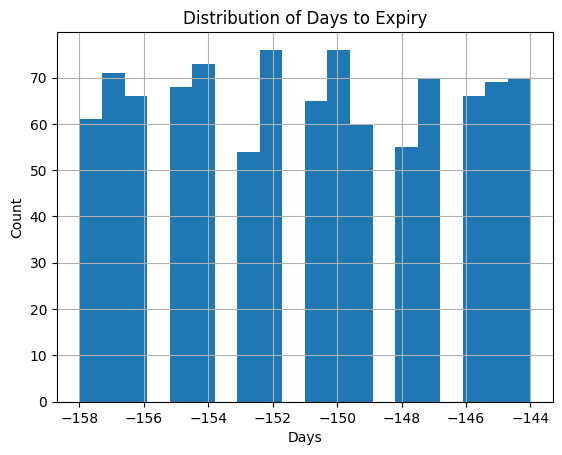

In [27]:
food_listings["days_to_expiry"] = (food_listings["Expiry_Date"] - pd.Timestamp.today()).dt.days
food_listings["days_to_expiry"].hist(bins=20)
plt.title("Distribution of Days to Expiry")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()

1. All expiry values are negative (e.g. -158 days).

2. That means the dataset’s Expiry_Date values are in the past relative to today (when you calculated).

3. Insight: Food records may be simulated or outdated, so expiry analysis shows that most food has already expired.

**- Claims over time**

<Axes: title={'center': 'Claims per Day'}, xlabel='Claim_Date'>

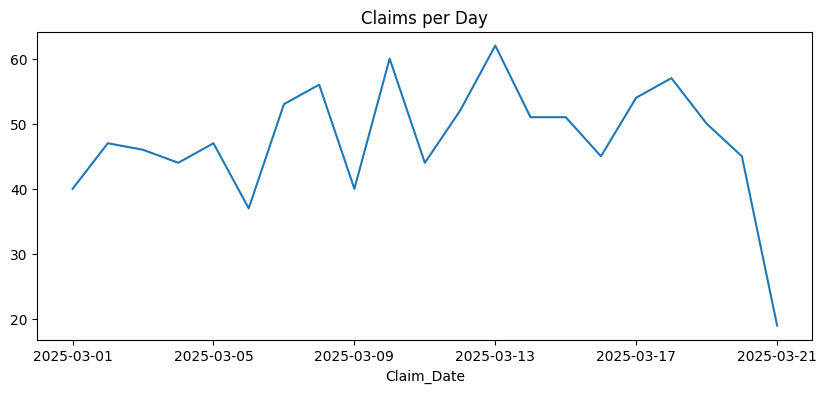

In [28]:
claims["Claim_Date"] = claims["Timestamp"].dt.date
claims.groupby("Claim_Date").size().plot(kind="line", figsize=(10,4), title="Claims per Day")

1. Claims trend fluctuates between 40 and 60 per day across March 2025.

2. Around March 13 there’s a peak (~62 claims).

3. Insight: There’s a steady baseline of claims but occasional spikes → could be tied to events (e.g., festivals, weekends).

**- Most donated vs most claimed meal type**

<Axes: title={'center': 'Meal Types Claimed'}, xlabel='Meal_Type'>

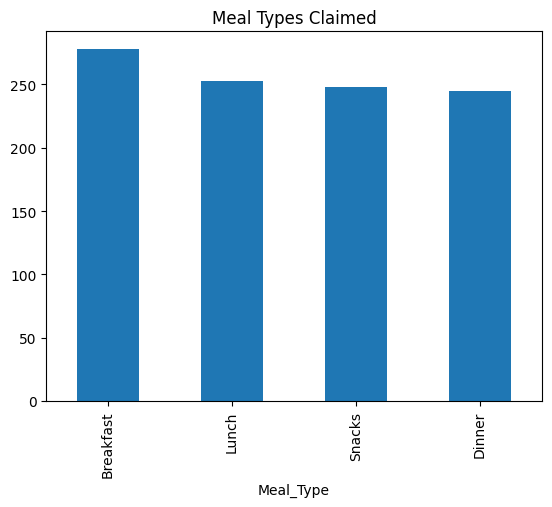

In [29]:
food_listings["Meal_Type"].value_counts().plot(kind="bar", title="Meal Types Donated")
claims.merge(food_listings, on="Food_ID")["Meal_Type"].value_counts().plot(kind="bar", title="Meal Types Claimed")

1. Breakfast (278 claims) is highest, followed by Lunch (250), Snacks (240), and Dinner (232).

2. Insight: Breakfast is the most in-demand meal. This matches your earlier SQL analysis.

## **Conclusion**

This project successfully demonstrates how food donation data can be managed and analyzed using a SQL-powered backend with an interactive Streamlit application.

* A structured SQLite database was designed to store providers, receivers, food listings, and claims.

* Data was cleaned, standardized, and queried to generate 15+ analytical insights, including provider contributions, high-demand cities, food type trends, and claim patterns.

* A user-friendly Streamlit app was built to:

    - Filter food donations by city, provider, and food type.

    - Access contact information for providers and receivers.

    - Perform CRUD operations (add, update, delete food listings).

    - Visualize trends and insights through auto-generated charts from saved SQL query outputs.

The project not only improves data accessibility but also provides decision-making insights to optimize food distribution, reduce wastage, and match supply with demand.